# Introduction


In this project, tasks includ developing software capable of extracting frames from the provided video clips that contain the full badminton court, detecting badminton court lines, identifying players within the court and tracking their movements over a series of consecutive video clips. This involves image processing technology, target detection and tracking algorithms. The libraries used in this notebook are described below:<br>
1. **OpenCV (cv2)**: It is an open source computer vision and machine learning library that can be used for image processing and analysis.
2. **numPy (np)**: A powerful Python library for numerical calculations. It provides a high-performance array object, and tools for working with these arrays. Can be used to perform various numerical operations to support data processing and analysis.
3. **os**: Provides a variety of operating system-related functions for processing files and directories, reading data set files, managing paths, etc.
4. **matplotlib.pyplot (plt)**: A plotting library, plt is its pyplot submodule, used to draw graphs and charts, which can be used in this project to visualize data and results.
5. **math**: The module provides a wide range of mathematical functions for performing various mathematical operations, which can be used to calculate distances, etc.
6. **shapely.geometry**: Used to process and operate plane geometric objects, and create polygonal objects using the detected vertices of the badminton court to facilitate subsequent operations.
7. **ultralytics.YOLO**: A library for object detection. The YOLO model can be used to identify, locate and track players on the badminton court.
8. **re**: Supports the use of regular expressions. Can be used to parse file names and search for specific pattern strings.
9. **numpy.linalg**: The linear algebra submodule of NumPy. The inv function is used to calculate the inverse of a matrix.<br>
#### Source: For built-in modules, just import. For external modules, they need to be installed via ‘! pip install [library name]’.
### Tasks implementation：
1. Since the court is mainly green, the green proportion is detected and Hough line detection is used to identify the lines within the frame. Frames with a certain proportion of green area and containing more than four lines are considered fully visible court.
2. Use Hough line detection to extract lines, then filter out lines of specific lengths, divide them into vertical and horizontal groups, determine the intersection points of these lines, identify the vertices of the court, and use the vertices to draw a 2D models of courts of single and double matches.
3. Use the tracking mode of YOLO to detect players in each frame, filter out players on the court by evaluating whether the vertices of bounding box fall within the court 2D model, and then annotate the filtered bounding box on each frame and associated tracking ID.
4. Since the player detection in Task 3 has used YOLO's tracking mode, using YOLO's default tracking algorithm BoT-SORT, each player has a unique tracking ID. For each tracking ID, create a corresponding Kalman filter for tracking. For every frame, use the Kalman filter to update the position of the target and mark the updated position on the image with a yellow dot.

In [1]:
import cv2 as cv
import numpy as np
import os
import matplotlib.pyplot as plt
import math
from shapely.geometry import Polygon, Point
from ultralytics import YOLO
import re
from numpy.linalg import inv
# !pip install ultralytics
# !pip install shapely

# Task 1


Convert each frame from BGR to HSV color space for better separation of color. Green area is calculated assuming that frames with less than 30% green proportion do not contain the fully visible court and they are discarded. The Hough transform is also used to identify court lines, and frames with fewer than four lines are also discarded. Two arrays of the names of fully visible frames of the single and double matches courts are returned.

In [2]:
def visible_court(image):
    '''
    Check if a court is visible in an image.
    '''
    hsv_image = cv.cvtColor(image,cv.COLOR_BGR2HSV)
    lower_green = np.array([45,50,60])
    upper_green = np.array([95,255,255])
    mask_green = cv.inRange(hsv_image,lower_green,upper_green)
    green_area = cv.countNonZero(mask_green)
    # If the green area is less than 30%, the court is not visible
    if green_area<(image.shape[0]*image.shape[1]*0.3):
        return False
    gray = cv.cvtColor(image,cv.COLOR_BGR2GRAY)
    blurred = cv.GaussianBlur(gray,(5,5),0)
    edges = cv.Canny(gray,50,200,apertureSize=3)
    lines = cv.HoughLinesP(edges,1,np.pi/180,threshold=90,minLineLength=300,maxLineGap=15)
    # If there are fewer than four lines detected, the court is not visible
    if lines is None or len(lines)<4:
        return False
    return True

def task1_solution(folder_name,start,end,frame_type):
    '''
    Process a range of image frames to identify visible courts.
    '''
    visible_courts = []
    folder_path = folder_name
    for i in range(start,end+1):
        frame_name = f"frame{i}-{frame_type}.jpeg"
        frame_path = os.path.join(folder_path, frame_name)
        image = cv.imread(frame_path)
        if image is not None and visible_court(image):
            visible_courts.append(frame_name)
    return visible_courts

single_names = task1_solution('SINGLEframes',1,501,'SINGLE')
double_names = task1_solution('DOUBLEframes',562,813,'DOUBLE')

[ WARN:0@10.367] global loadsave.cpp:248 findDecoder imread_('SINGLEframes/frame134-SINGLE.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@10.705] global loadsave.cpp:248 findDecoder imread_('SINGLEframes/frame154-SINGLE.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@12.270] global loadsave.cpp:248 findDecoder imread_('SINGLEframes/frame243-SINGLE.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@12.485] global loadsave.cpp:248 findDecoder imread_('SINGLEframes/frame256-SINGLE.jpeg'): can't open/read file: check file path/integrity
[ WARN:0@12.646] global loadsave.cpp:248 findDecoder imread_('SINGLEframes/frame266-SINGLE.jpeg'): can't open/read file: check file path/integrity


# Task 2

1. The image is first converted to HSV color space to better separate the green color associated with badminton courts. Apply a binary mask to highlight areas of the court and suppress irrelevant areas. Use Canny edge detection to identify court boundary lines. Utilize Hough line transform to identify lines from detected edges and classify these lines into horizontal and vertical lines. The detected lines are further filtered based on the badminton court boundary length to further filter lines.<br>
2. Calculate the intersection points of the filtered horizontal and vertical lines, then filter the maximum and minimum values of x, y coordinates to determine the four vertices of the court, use the four vertices to draw the 2D model of the single and double matches courts, and then draw the results on every frame.
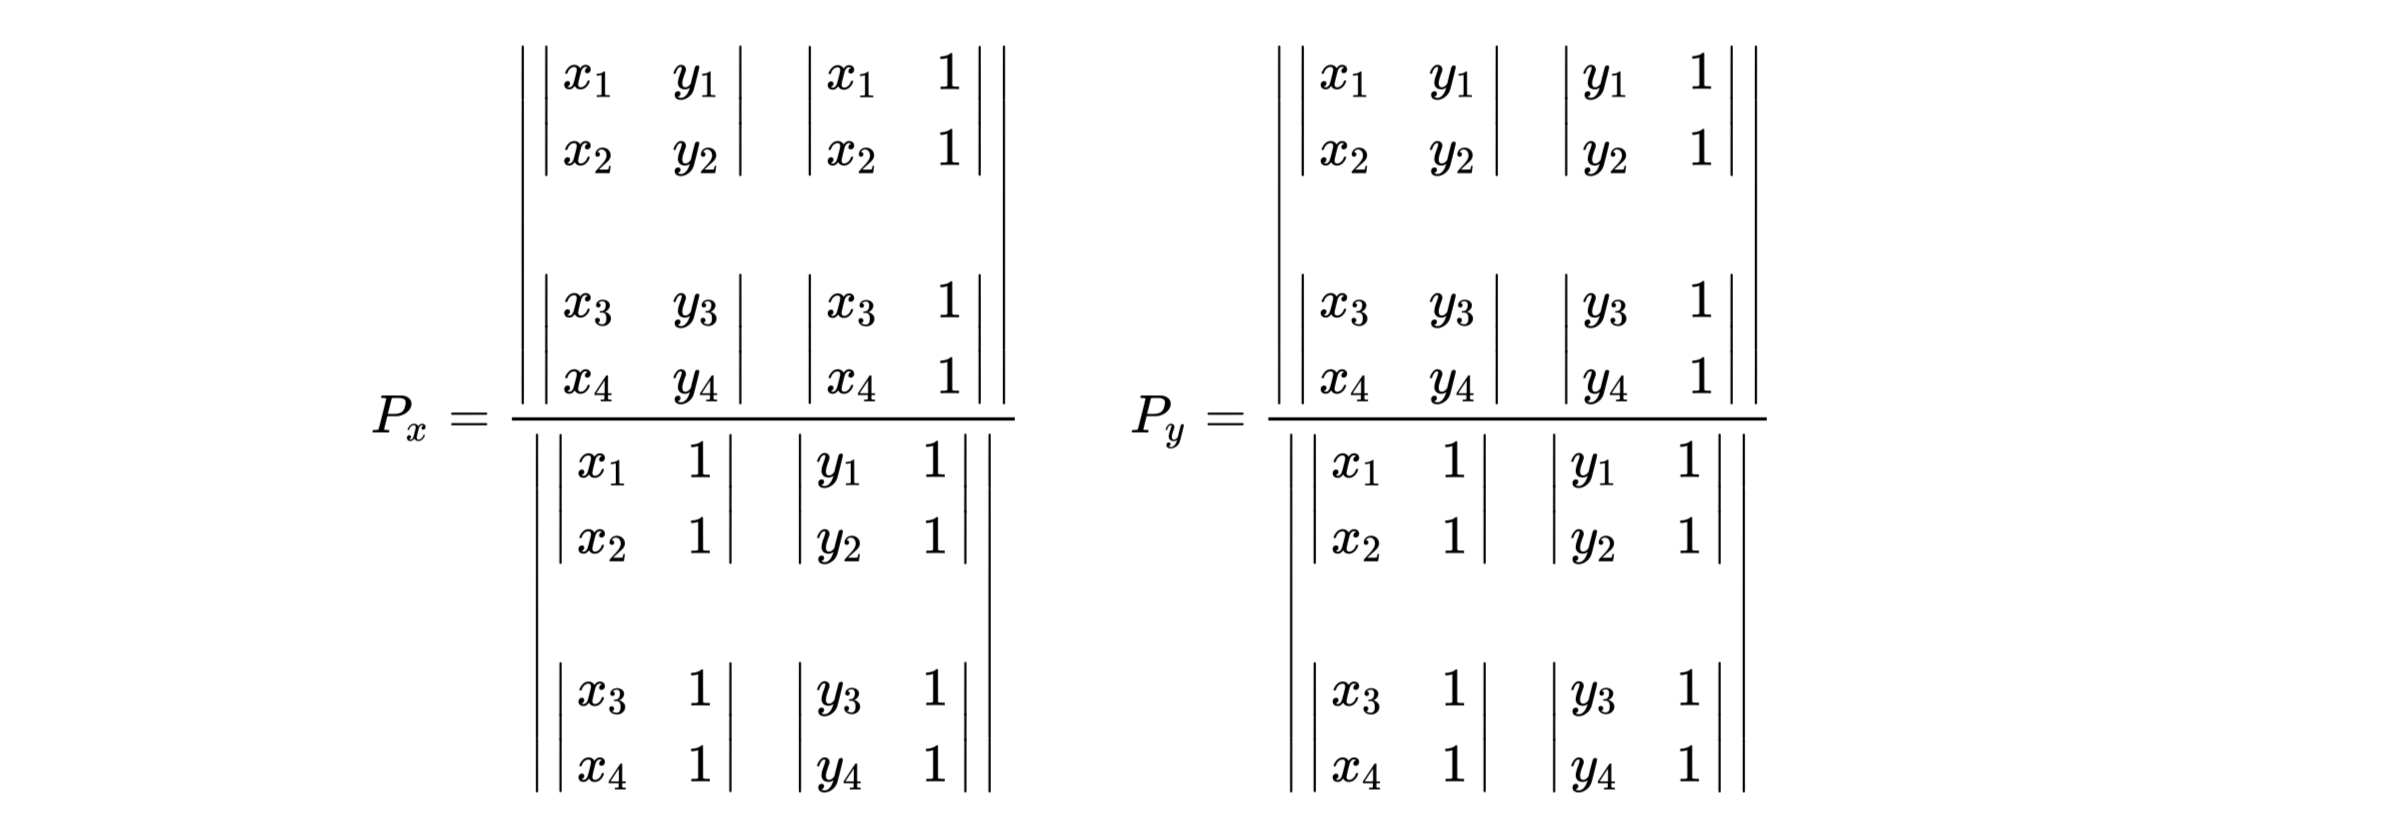
$$
P_x = \frac{(x_1 y_2 - y_1 x_2)(x_3 - x_4) - (x_1 - x_2)(x_3 y_4 - y_3 x_4)}{(x_1 - x_2)(y_3 - y_4) - (y_1 - y_2)(x_3 - x_4)}
$$

$$
P_y = \frac{(x_1 y_2 - y_1 x_2)(y_3 - y_4) - (y_1 - y_2)(x_3 y_4 - y_3 x_4)}{(x_1 - x_2)(y_3 - y_4) - (y_1 - y_2)(x_3 - x_4)}
$$

In [3]:
def getCourtLines(img,dx,dy): 
    '''
    Find the court lines in an image
    '''
    hsv_image = cv.cvtColor(img,cv.COLOR_BGR2HSV)
    lower_green = np.array([40,0,0])
    upper_green = np.array([90,255,255])
    mask_green = cv.inRange(hsv_image,lower_green,upper_green)
    im = cv.cvtColor(img,cv.COLOR_BGR2GRAY)
    res = cv.bitwise_and(im,im,mask=mask_green)
    ret,th1 = cv.threshold(res,190,255,cv.THRESH_BINARY) 
    edges = cv.Canny(th1,80,160,apertureSize=3)
    # Detect lines in the image using the probabilistic hough line transform
    lines = cv.HoughLinesP(edges,1,np.pi/90,20,None,70,200)  
    h_lines = []
    v_lines = []
    for line in lines: # Divide lines into horizontal and vertical lines
        for x1,y1,x2,y2 in line:
            if (x1>200)and(x2>200):
                if abs(y2-y1)<dy:
                    h_lines.append(line)
                elif abs(x2-x1)<dx:
                    v_lines.append(line)
    h = [] 
    v = [] 
    for s in h_lines: 
        for x1,y1,x2,y2 in s:
            if  (350.0<math.dist([x1,y1],[x2,y2])<500.0)or(870.0<math.dist([x1,y1],[x2,y2])<890.0): 
                h.append(s)
    for s in v_lines: 
        for x1,y1,x2,y2 in s:
            if (400.0<math.dist([x1,y1],[x2,y2])<600): 
                v.append(s)   
    return h, v

def find_vertices(h, v):
    '''
    Find the four vertices of a court
    '''
    Px = []
    Py = []
    for h_line in h:
        for v_line in v:
            x1,y1,x2,y2 = h_line[0]
            x3,y3,x4,y4 = v_line[0]
            px = ((x1*y2-y1*x2)*(x3-x4)-(x1-x2)*(x3*y4-y3*x4))/((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4))
            py = ((x1*y2-y1*x2)*(y3-y4)-(y1-y2)*(x3*y4-y3*x4))/((x1-x2)*(y3-y4)-(y1-y2)*(x3-x4))
            Px.append(px)
            Py.append(py)
    points = np.float32(np.column_stack((Px,Py)))
    # From the top and bottom points, find the left and right points
    top_points = points[points[:,1] == points[:,1].min()]
    bottom_points = points[points[:,1] == points[:,1].max()]
    bottom_left = bottom_points[bottom_points[:,0].argmin()]
    bottom_right = bottom_points[bottom_points[:,0].argmax()]
    top_left = top_points[top_points[:,0].argmin()]
    top_right = top_points[top_points[:,0].argmax()]
    vertices = np.array([top_left,top_right,bottom_right,bottom_left])
    return vertices

In [4]:
img_sin = cv.imread('SINGLEframes/frame445-SINGLE.jpeg')
img_dou = cv.imread('DOUBLEframes/frame690-DOUBLE.jpeg')

h_lines,v_lines = getCourtLines(img_sin,300,1)
single_v = find_vertices(h_lines, v_lines)
print("Coordinates of four vertices of single court：")
print(single_v)
h_lines,v_lines = getCourtLines(img_dou,300,1)
double_v = find_vertices(h_lines,v_lines)
print("Coordinates of four vertices of double court：")
print(double_v)

Coordinates of four vertices of single court：
[[     369.45         341]
 [     902.69         341]
 [     1083.6         712]
 [        204         712]]
Coordinates of four vertices of double court：
[[     416.12         326]
 [     857.98         326]
 [     1027.9         674]
 [     247.17         674]]


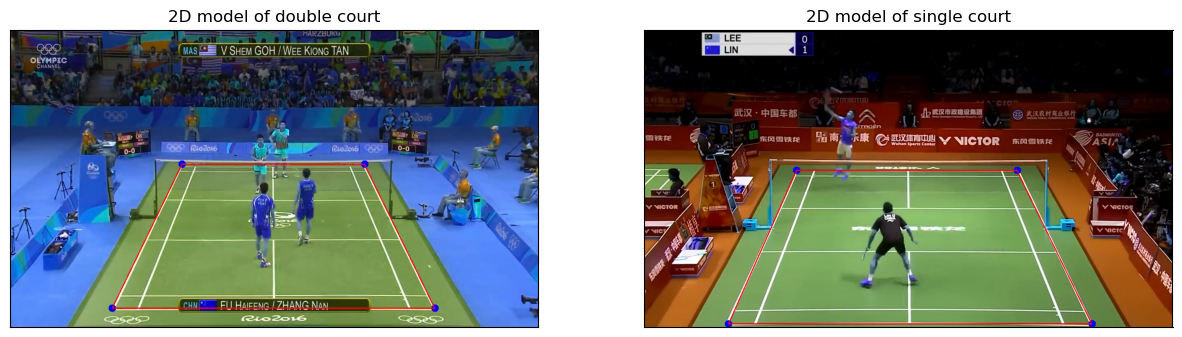

In [5]:
for cx,cy in double_v:
    cx = np.round(cx).astype(int)
    cy = np.round(cy).astype(int)
    cv.circle(img_dou,(cx,cy),radius=9,color=(0,0,255),thickness=-1)
pts = double_v.reshape((-1,1,2)).astype(int)
# Draw polylines connecting the vertices in 'double_v' on the image.
cv.polylines(img_dou,[pts],isClosed=True,color=(255,0,0),thickness=2)
for cx,cy in single_v:
    cx = np.round(cx).astype(int)
    cy = np.round(cy).astype(int)
    cv.circle(img_sin,(cx,cy),radius=9,color=(0,0,255),thickness=-1)
pts = single_v.reshape((-1,1,2)).astype(int)
# Draw polylines connecting the vertices in 'single_v' on the image.
cv.polylines(img_sin,[pts],isClosed=True,color=(255,0,0),thickness=2)

cv.imwrite('2D_model_double.jpeg',img_dou)
cv.imwrite('2D_model_single.jpeg',img_sin)

plt.figure(figsize=(15,10))
plt.subplot(1,2,1)
plt.imshow(img_dou)
plt.title('2D model of double court'),plt.xticks([]),plt.yticks([])
plt.subplot(1,2,2)
plt.imshow(img_sin)
plt.title('2D model of single court'),plt.xticks([]),plt.yticks([])
plt.show()

In [6]:
def draw_court_on_images(input_dir,vertices):
    '''
    Draw court lines on all images
    '''
    for img_name in os.listdir(input_dir):
        img_path = os.path.join(input_dir,img_name)
        img = cv.imread(img_path)
        if img is not None:
            pts = vertices.reshape((-1,1,2)).astype(int)
            cv.polylines(img,[pts],isClosed=True,color=(255,0,0),thickness=2)
            cv.imwrite(img_path,img)
            
draw_court_on_images('SINGLEframes',single_v)
draw_court_on_images('DOUBLEframes',double_v)

# Task 3


1. A function, box_in_polygon(box, polygon) was created to detect whether the four vertices of the box are inside the polygon. Because the court boundary is a polygon instead of a rectangle in the image, IoU cannot be used. Using the vertices of the single match court and the double match court, create separate polygons for the single and double matches courts.
2. Use the track mode of the pre-trained YOLOv8 model to detect and track all people in the image frame by setting classes=0. Use the xyxy attribute, conf attribute and id attribute of results[0].boxes to obtain the coordinate value, confidence and tracking id of the bounding box in each frame respectively. Use the box_in_polygon(box, polygon) function to determine whether the box has at least one vertex inside the polygon to filter bounding boxes within the court.
3. For each bounding box within the court in each frame, if it is newly detected, a Kalman filter is initialized for it; if it already exists, the corresponding filter continues to track it. Then, the Kalman filter is used to update the prediction of the target position, including updating the prediction uncertainty, calculating the Kalman gain, state correction, etc. Then mark that location with a yellow dot on the image.

In [7]:
model = YOLO('yolov8n.pt')
os.makedirs("results_single",exist_ok=True)
os.makedirs("results_double",exist_ok=True)
polygon_single = Polygon(single_v)
polygon_double = Polygon(double_v)

def box_in_polygon(box,polygon):
    '''
    Check if a bounding box in the polygon
    '''
    corners = [(box[0],box[1]),(box[2],box[1]),(box[2],box[3]),(box[0],box[3])]
    return any(polygon.contains(Point(corner)) for corner in corners)

class KalmanFilter():
    '''
    Implement a Kalman Filter for tracking and estimating the position and velocity of an object for a two-dimensional space.
    '''
    def __init__(self,
                 xinit:int = 0,
                 yinit:int = 0,
                 fps:int = 30,
                 std_a:float = 0.001,
                 std_x:float = 0.0045,
                 std_y:float = 0.01,
                 cov:float = 100000) ->None:
        self.S = np.array([xinit,0,0,yinit,0,0])
        self.dt = 1/fps
        self.F = np.array([[1,self.dt,0.5*(self.dt*self.dt),0,0,0],
                           [0,1,self.dt,0,0,0],[0,0,1,0,0,0],
                           [0,0,0,1,self.dt,0.5*self.dt*self.dt],
                           [0,0,0,0,1,self.dt],[0,0,0,0,0,1]])
        self.std_a = std_a
        self.Q = np.array([
            [
                0.25*self.dt*self.dt*self.dt*self.dt,0.5*self.dt*
                self.dt*self.dt,0.5*self.dt*self.dt,0,0,0
            ],
            [
                0.5*self.dt*self.dt*self.dt,self.dt*self.dt,self.dt,
                0,0,0
            ], [0.5*self.dt*self.dt,self.dt,1,0,0,0],
            [
                0,0,0,0.25*self.dt*self.dt*self.dt*self.dt,
                0.5*self.dt*self.dt*self.dt,0.5*self.dt*self.dt
            ],
            [
                0,0,0,0.5*self.dt*self.dt*self.dt,self.dt*self.dt,
                self.dt
            ],[0,0,0,0.5*self.dt*self.dt,self.dt,1]
        ])*self.std_a*self.std_a
        self.std_x = std_x
        self.std_y = std_y
        self.R = np.array([[self.std_x*self.std_x,0],
                           [0,self.std_y*self.std_y]])
        self.cov = cov
        self.P = np.array([[self.cov,0,0,0,0,0],
                           [0,self.cov,0,0,0,0],
                           [0,0,self.cov,0,0,0],
                           [0,0,0,self.cov,0,0],
                           [0,0,0,0,self.cov,0],
                           [0,0,0,0,0,self.cov]])
        self.H = np.array([[1,0,0,0,0,0],[0,0,0,1,0,0]])
        self.I = np.array([[1,0,0,0,0,0],[0,1,0,0,0,0],
                           [0,0,1,0,0,0],[0,0,0,1,0,0],
                           [0,0,0,0,1,0],[0,0,0,0,0,1]])
        self.S_pred = None
        self.P_pred = None
        self.K = None
        self.S_hist = [self.S]
        self.K_hist = []
        self.P_hist = [self.P]
    def pred_new_state(self):
        self.S_pred = self.F.dot(self.S)
    def pred_next_uncertainity(self):
        self.P_pred = self.F.dot(self.P).dot(self.F.T)+self.Q
    def get_Kalman_gain(self):
        self.K = self.P_pred.dot(self.H.T).dot(
            inv(self.H.dot(self.P_pred).dot(self.H.T)+self.R))
        self.K_hist.append(self.K)
    def state_correction(self,z):
        if z == [None,None]:
            self.S = self.S_pred
        else:
            self.S = self.S_pred++self.K.dot(z-self.H.dot(self.S_pred))
        self.S_hist.append(self.S)
    def uncertainity_correction(self,z):
        if z != [None,None]:
            self.l1 = self.I-self.K.dot(self.H)
            self.P = self.l1.dot(self.P_pred).dot(self.l1.T)+self.K.dot(
                self.R).dot(self.K.T)
        self.P_hist.append(self.P)

def task3_solution(names,folder,result,polygon):
    '''
    Processes images for object tracking within a defined polygonal area, using Kalman Filter for prediction and updating object states.
    '''
    trackers = {}
    for name in names:
        path = os.path.join(folder,name)
        image = cv.imread(path)
        results = model.track(path,conf=0.3,classes=0) # use classes=0 to only detect person
        boxes = results[0].boxes.xyxy
        confs = results[0].boxes.conf
        ids = results[0].boxes.id
        for i, box in enumerate(boxes): # Iterate through each detected bounding box.
            box_list = box.tolist()
            id = ids[i] if ids[i] is not None else i
            if box_in_polygon(box_list,polygon):
                if id not in trackers: # Initialize a Kalman Filter for the object if it doesn't already exist
                    trackers[id] = KalmanFilter(xinit=box_list[0],yinit=box_list[1],fps=30)
                z = [box_list[0]+(box_list[2]-box_list[0])/2,box_list[1]+(box_list[3]-box_list[1])/2]
                trackers[id].pred_new_state()
                trackers[id].pred_next_uncertainity()
                trackers[id].get_Kalman_gain()
                trackers[id].state_correction(z)
                trackers[id].uncertainity_correction(z)
                # Get the predicted center from the updated state
                predicted_center = [int(trackers[id].S[0]),int(trackers[id].S[3])]
                cv.circle(image,(predicted_center[0],predicted_center[1]),radius=7,color=(0,255,255),thickness=-1)
                cv.rectangle(image,(int(box_list[0]),int(box_list[1])),(int(box_list[2]),int(box_list[3])),(0,255,0),2)
                label = f"conf:{confs[i]:.2f}, ID:{id}"
                cv.putText(image,label,(int(box_list[0]),int(box_list[1]-10)),cv.FONT_HERSHEY_SIMPLEX,0.7,(0,0,255),2)
        save_path = os.path.join(result,name)
        cv.imwrite(save_path,image)

task3_solution(single_names,'SINGLEframes',"results_single",polygon_single)
task3_solution(double_names,'DOUBLEframes',"results_double",polygon_double)

100%|████████████████████████████████████████████████████████████████████████████████| 6.23M/6.23M [00:00<00:00, 21.5MB/s]



image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame19-SINGLE.jpeg: 384x640 2 persons, 54.5ms
Speed: 2.9ms preprocess, 54.5ms inference, 8.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame20-SINGLE.jpeg: 384x640 2 persons, 145.5ms
Speed: 28.3ms preprocess, 145.5ms inference, 0.8ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame21-SINGLE.jpeg: 384x640 2 persons, 64.4ms
Speed: 2.1ms preprocess, 64.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame22-SINGLE.jpeg: 384x640 2 persons, 39.8ms
Speed: 0.9ms preprocess, 39.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame23-SINGLE.jpeg: 384x640 2 persons, 40.9ms
Speed: 1.0ms preprocess, 40.9ms inference, 0.4ms postprocess per


image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame59-SINGLE.jpeg: 384x640 2 persons, 44.9ms
Speed: 1.0ms preprocess, 44.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame60-SINGLE.jpeg: 384x640 2 persons, 44.0ms
Speed: 0.9ms preprocess, 44.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame61-SINGLE.jpeg: 384x640 2 persons, 48.0ms
Speed: 1.1ms preprocess, 48.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame62-SINGLE.jpeg: 384x640 2 persons, 42.4ms
Speed: 1.0ms preprocess, 42.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame63-SINGLE.jpeg: 384x640 2 persons, 43.8ms
Speed: 1.1ms preprocess, 43.8ms inference, 0.4ms postprocess per im


image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame99-SINGLE.jpeg: 384x640 1 person, 43.3ms
Speed: 1.1ms preprocess, 43.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame100-SINGLE.jpeg: 384x640 2 persons, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame101-SINGLE.jpeg: 384x640 1 person, 44.7ms
Speed: 1.1ms preprocess, 44.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame102-SINGLE.jpeg: 384x640 1 person, 43.0ms
Speed: 0.9ms preprocess, 43.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame103-SINGLE.jpeg: 384x640 2 persons, 42.7ms
Speed: 1.0ms preprocess, 42.7ms inference, 0.4ms postprocess per i


image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame140-SINGLE.jpeg: 384x640 2 persons, 42.6ms
Speed: 1.0ms preprocess, 42.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame141-SINGLE.jpeg: 384x640 2 persons, 41.8ms
Speed: 0.9ms preprocess, 41.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame142-SINGLE.jpeg: 384x640 2 persons, 42.1ms
Speed: 1.0ms preprocess, 42.1ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame143-SINGLE.jpeg: 384x640 2 persons, 43.1ms
Speed: 0.9ms preprocess, 43.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame144-SINGLE.jpeg: 384x640 2 persons, 42.8ms
Speed: 1.0ms preprocess, 42.8ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame181-SINGLE.jpeg: 384x640 2 persons, 44.2ms
Speed: 1.0ms preprocess, 44.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame182-SINGLE.jpeg: 384x640 2 persons, 45.5ms
Speed: 0.9ms preprocess, 45.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame183-SINGLE.jpeg: 384x640 2 persons, 45.7ms
Speed: 1.0ms preprocess, 45.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame184-SINGLE.jpeg: 384x640 2 persons, 44.1ms
Speed: 1.0ms preprocess, 44.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame185-SINGLE.jpeg: 384x640 2 persons, 48.8ms
Speed: 1.1ms preprocess, 48.8ms inference, 0.5ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame221-SINGLE.jpeg: 384x640 3 persons, 43.3ms
Speed: 1.0ms preprocess, 43.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame222-SINGLE.jpeg: 384x640 3 persons, 42.6ms
Speed: 1.0ms preprocess, 42.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame223-SINGLE.jpeg: 384x640 3 persons, 46.3ms
Speed: 1.1ms preprocess, 46.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame224-SINGLE.jpeg: 384x640 3 persons, 44.0ms
Speed: 1.0ms preprocess, 44.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame225-SINGLE.jpeg: 384x640 2 persons, 42.8ms
Speed: 1.1ms preprocess, 42.8ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame263-SINGLE.jpeg: 384x640 2 persons, 45.9ms
Speed: 1.1ms preprocess, 45.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame264-SINGLE.jpeg: 384x640 2 persons, 46.2ms
Speed: 1.1ms preprocess, 46.2ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame265-SINGLE.jpeg: 384x640 2 persons, 44.6ms
Speed: 1.0ms preprocess, 44.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame267-SINGLE.jpeg: 384x640 2 persons, 44.7ms
Speed: 1.0ms preprocess, 44.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame268-SINGLE.jpeg: 384x640 2 persons, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame304-SINGLE.jpeg: 384x640 2 persons, 43.9ms
Speed: 1.3ms preprocess, 43.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame305-SINGLE.jpeg: 384x640 2 persons, 43.7ms
Speed: 0.9ms preprocess, 43.7ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame306-SINGLE.jpeg: 384x640 2 persons, 43.7ms
Speed: 1.1ms preprocess, 43.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame307-SINGLE.jpeg: 384x640 2 persons, 43.1ms
Speed: 1.0ms preprocess, 43.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame308-SINGLE.jpeg: 384x640 2 persons, 43.2ms
Speed: 1.0ms preprocess, 43.2ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame344-SINGLE.jpeg: 384x640 2 persons, 43.5ms
Speed: 1.0ms preprocess, 43.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame345-SINGLE.jpeg: 384x640 2 persons, 45.1ms
Speed: 1.2ms preprocess, 45.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame346-SINGLE.jpeg: 384x640 2 persons, 44.7ms
Speed: 1.0ms preprocess, 44.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame347-SINGLE.jpeg: 384x640 2 persons, 46.0ms
Speed: 1.1ms preprocess, 46.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame348-SINGLE.jpeg: 384x640 2 persons, 44.5ms
Speed: 1.0ms preprocess, 44.5ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame384-SINGLE.jpeg: 384x640 2 persons, 47.6ms
Speed: 1.0ms preprocess, 47.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame385-SINGLE.jpeg: 384x640 2 persons, 44.1ms
Speed: 1.5ms preprocess, 44.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame386-SINGLE.jpeg: 384x640 2 persons, 44.8ms
Speed: 1.0ms preprocess, 44.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame387-SINGLE.jpeg: 384x640 2 persons, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame388-SINGLE.jpeg: 384x640 2 persons, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame424-SINGLE.jpeg: 384x640 2 persons, 45.2ms
Speed: 1.0ms preprocess, 45.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame425-SINGLE.jpeg: 384x640 2 persons, 44.6ms
Speed: 1.0ms preprocess, 44.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame426-SINGLE.jpeg: 384x640 2 persons, 43.8ms
Speed: 1.0ms preprocess, 43.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame427-SINGLE.jpeg: 384x640 2 persons, 45.0ms
Speed: 1.0ms preprocess, 45.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame428-SINGLE.jpeg: 384x640 2 persons, 44.3ms
Speed: 1.0ms preprocess, 44.3ms inference, 0.6ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame464-SINGLE.jpeg: 384x640 2 persons, 41.9ms
Speed: 1.3ms preprocess, 41.9ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame465-SINGLE.jpeg: 384x640 2 persons, 42.4ms
Speed: 1.1ms preprocess, 42.4ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame466-SINGLE.jpeg: 384x640 2 persons, 42.6ms
Speed: 1.0ms preprocess, 42.6ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame467-SINGLE.jpeg: 384x640 2 persons, 42.0ms
Speed: 1.0ms preprocess, 42.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/SINGLEframes/frame468-SINGLE.jpeg: 384x640 2 persons, 42.1ms
Speed: 1.1ms preprocess, 42.1ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame592-DOUBLE.jpeg: 384x640 4 persons, 45.1ms
Speed: 1.0ms preprocess, 45.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame593-DOUBLE.jpeg: 384x640 3 persons, 44.6ms
Speed: 1.0ms preprocess, 44.6ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame594-DOUBLE.jpeg: 384x640 3 persons, 44.1ms
Speed: 0.9ms preprocess, 44.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame595-DOUBLE.jpeg: 384x640 3 persons, 43.9ms
Speed: 1.0ms preprocess, 43.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame596-DOUBLE.jpeg: 384x640 3 persons, 43.4ms
Speed: 1.0ms preprocess, 43.4ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame632-DOUBLE.jpeg: 384x640 4 persons, 43.9ms
Speed: 1.0ms preprocess, 43.9ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame633-DOUBLE.jpeg: 384x640 3 persons, 44.2ms
Speed: 1.1ms preprocess, 44.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame634-DOUBLE.jpeg: 384x640 3 persons, 45.4ms
Speed: 0.9ms preprocess, 45.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame635-DOUBLE.jpeg: 384x640 3 persons, 44.5ms
Speed: 1.1ms preprocess, 44.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame636-DOUBLE.jpeg: 384x640 4 persons, 42.7ms
Speed: 1.0ms preprocess, 42.7ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame672-DOUBLE.jpeg: 384x640 2 persons, 43.7ms
Speed: 1.0ms preprocess, 43.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame673-DOUBLE.jpeg: 384x640 2 persons, 43.4ms
Speed: 1.0ms preprocess, 43.4ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame674-DOUBLE.jpeg: 384x640 3 persons, 42.1ms
Speed: 1.0ms preprocess, 42.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame675-DOUBLE.jpeg: 384x640 2 persons, 42.5ms
Speed: 0.9ms preprocess, 42.5ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame676-DOUBLE.jpeg: 384x640 3 persons, 44.9ms
Speed: 1.0ms preprocess, 44.9ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame712-DOUBLE.jpeg: 384x640 3 persons, 43.0ms
Speed: 1.2ms preprocess, 43.0ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame713-DOUBLE.jpeg: 384x640 3 persons, 43.3ms
Speed: 1.0ms preprocess, 43.3ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame714-DOUBLE.jpeg: 384x640 3 persons, 42.7ms
Speed: 1.0ms preprocess, 42.7ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame715-DOUBLE.jpeg: 384x640 3 persons, 42.1ms
Speed: 0.9ms preprocess, 42.1ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame716-DOUBLE.jpeg: 384x640 3 persons, 42.4ms
Speed: 1.1ms preprocess, 42.4ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame752-DOUBLE.jpeg: 384x640 4 persons, 44.7ms
Speed: 1.1ms preprocess, 44.7ms inference, 0.6ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame753-DOUBLE.jpeg: 384x640 3 persons, 44.8ms
Speed: 1.0ms preprocess, 44.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame754-DOUBLE.jpeg: 384x640 4 persons, 44.2ms
Speed: 1.0ms preprocess, 44.2ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame755-DOUBLE.jpeg: 384x640 3 persons, 44.3ms
Speed: 1.0ms preprocess, 44.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame756-DOUBLE.jpeg: 384x640 3 persons, 43.4ms
Speed: 1.0ms preprocess, 43.4ms inference, 0.4ms postprocess p


image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame792-DOUBLE.jpeg: 384x640 3 persons, 46.0ms
Speed: 1.2ms preprocess, 46.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame793-DOUBLE.jpeg: 384x640 3 persons, 43.0ms
Speed: 1.0ms preprocess, 43.0ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame794-DOUBLE.jpeg: 384x640 3 persons, 43.8ms
Speed: 0.9ms preprocess, 43.8ms inference, 0.4ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame795-DOUBLE.jpeg: 384x640 3 persons, 44.1ms
Speed: 1.0ms preprocess, 44.1ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)

image 1/1 /Users/wangyixin/Desktop/CV/Summative/DOUBLEframes/frame796-DOUBLE.jpeg: 384x640 3 persons, 51.8ms
Speed: 0.9ms preprocess, 51.8ms inference, 0.5ms postprocess p

# Task 4

Based on task 3, target detection and tracking have been implemented. Using YOLO's tracking mode, the default tracking algorithm BoT-SORT tracks each object detected in the image sequence frame and assigns it a unique ID. For each bounding box within the court in every frame, if it is newly detected, a Kalman filter is initialized for it; if it already exists, the corresponding filter continues to track it. A video is then generated to show the tracking results.

In [8]:
def images2video(folder,output,fps=30):
    '''
    Use the images in the folder to generate a video
    '''
    images = [img for img in os.listdir(folder) if img.endswith(".jpeg")]
    images.sort(key=lambda x:int(re.findall(r'\d+',x)[0]))
    first_image_path = os.path.join(folder,images[0])
    frame = cv.imread(first_image_path)
    h,w,l = frame.shape
    f = cv.VideoWriter_fourcc(*'mp4v')
    video = cv.VideoWriter(output,f,fps,(w,h))
    for image in images:
        video.write(cv.imread(os.path.join(folder,image)))
    video.release()
    
images2video('results_single','video_single.mp4')
images2video('results_double','video_double.mp4')

In order to submit to Gradescope, the number of images needs to be reduced.

In [9]:
def reduce_images(folder):
    '''
    Reduce the number of images in the folder
    '''
    images = [img for img in os.listdir(folder) if img.endswith(".jpeg")]
    images.sort(key=lambda x:int(re.findall(r'\d+',x)[0]))
    for i, image in enumerate(images):
        if (i+1)%10!=0:
            os.remove(os.path.join(folder,image))

reduce_images("results_single")
reduce_images("results_double")

# Outputs

1. 2D_model_single.jpeg
2. 2D_model_double.jpeg
3. results_single (object detect and track results)
4. results_double (object detect and track results)
5. video_single.mp4
6. video_double.mp4

# References
1. https://github.com/ChaosAdmStudent/qualitative-badminton-player-analysis/blob/main/1)%20Court%20Line%20Detection.ipynb 
2. https://github.com/mehtamohit013/object-detection-kalman 